# Analisis COVID-19

En el presente Notebook se presenta un rapido análisis de la situacion de colombia frente a la pandemia de global del covid-19

In [1]:
# importing the required libraries
import pandas as pd

# Visualisation libraries
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import folium 
from folium import plugins

# Manipulating the default plot size
plt.rcParams['figure.figsize'] = 10, 12

# Disable warnings 
import warnings
warnings.filterwarnings('ignore')

import requests
import datetime as dt
from pandas.io.json import json_normalize
from pandas_profiling import ProfileReport
from datetime import datetime
from fbprophet import Prophet

## Leyendo los sets de datos de la OMS directamente desde la fuente

El Centro europeo para la prevención y el control de enfermedades profiere un conjunto de datos actualizado diariamente para todos los paises, este informe contiene las muertes y el toral de casos confirmados para los paises que reportan la información todos los dias.

A continuación se muestra como realizar el consumo de estos datos desde dicha plataforma directamante haciendo uso de pandas.

In [2]:
# Se crea el dataset con los datos
url = 'https://opendata.ecdc.europa.eu/covid19/casedistribution/json/' 
r = requests.get(url)
j = json_normalize(r.json()['records'])
df = pd.DataFrame.from_dict(j)

In [3]:
# Los datos unicamente para colombia son: (para ver todos quitar .head())
df.loc[df['countriesAndTerritories']=='Colombia'].head()

,dateRep,day,month,year,cases,deaths,countriesAndTerritories,geoId,countryterritoryCode,popData2018,continentExp
2872,30/04/2020,30,4,2020,262,9,Colombia,CO,COL,49648685,America
2873,29/04/2020,29,4,2020,352,16,Colombia,CO,COL,49648685,America
2874,28/04/2020,28,4,2020,218,10,Colombia,CO,COL,49648685,America
2875,27/04/2020,27,4,2020,237,10,Colombia,CO,COL,49648685,America
2876,26/04/2020,26,4,2020,261,8,Colombia,CO,COL,49648685,America


Nos encontramos en la era de la información y como tal hay multiples fuentes, la pandemia global del coronavirus no es la excepción. Dabido a esto existen multiples fuentes desde las cuales se puede extraer información otra de las fuentes es el [El Centro de Ciencia e Ingeniería de Sistemas (CSSE) en JHU (Universidad de Johns Hopkins)](https://systems.jhu.edu/), la cual ha dispuesto su información en un repositorio de github desde el cual actualizan diariamente los datos y que esta disponible en el siguiente enlace: 

[Johns Hopkins Github repository](https://github.com/CSSEGISandData/COVID-19)

A continuación se muestra como consumir estos datos para poder hacer analisis con ellos.


In [4]:
# Enlaces a los archivos que se actualizan diariamente en Github
casos = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
muertes = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
recuperados = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv'

In [5]:
# Se consumen los enlaces desde la libreria pandas
confirmed = pd.read_csv(casos)
deaths = pd.read_csv(muertes)
recovered = pd.read_csv(recuperados)
# Se cambia el nombre de 'Country/Region' a 'Country' por facilidad de uso.  
confirmed.rename(columns={'Country/Region':'Country'}, inplace=True)
recovered.rename(columns={'Country/Region':'Country'}, inplace=True)
deaths.rename(columns={'Country/Region':'Country'}, inplace=True)
# Se quitan algunas columnas que no son tan relevantes en el proceso.
confirmed = confirmed.drop(["Province/State","Lat","Long"], axis=1)
recovered = recovered.drop(["Province/State","Lat","Long"], axis=1)
deaths = deaths.drop(["Province/State","Lat","Long"], axis=1)
# Se realiza agrupación de los datos por pais
confirmed = confirmed.groupby(confirmed['Country']).aggregate('sum')
recovered = recovered.groupby(recovered['Country']).aggregate('sum')
deaths = deaths.groupby(deaths['Country']).aggregate('sum')
confirmed = confirmed.T
recovered = recovered.T
deaths = deaths.T

Ahora se hace una calculo de los casos nuevos que se van presentando dia a dia, esto con el fin de poder estimar el crecimiento de los casos a travez del tiempo. 

In [6]:
# Copia de los confirmados
new_cases = confirmed.copy()

for day in range(1, len(confirmed)):
    new_cases.iloc[day] = confirmed.iloc[day] - confirmed.iloc[day -1]
    
print(new_cases[['Colombia','Spain','US','China']].tail(10))

Country  Colombia  Spain     US  China
4/20/20       185   1536  25517     12
4/21/20       172   3968  27539     36
4/22/20       207   4211  28486     15
4/23/20       205   4635  28819     16
4/24/20       320   6740  36188     15
4/25/20       261   3995  32796     10
4/26/20       237   2870  27631      3
4/27/20       218   2793  22412      6
4/28/20       352   2706  24385     22
4/29/20       258   4771  27327      4


Al realizar una comparación del calculo realizado con los datos de la Universidad Johns Hopkins con respecto a los que reporta el centro europeo de prevención de enfermedades da que estos son consistentes para el numero de casos nuevos de los ultimos dias.

|   Dia   | John Hopkins | ECDC |
|---------|--------------|------|
| 4/15/20 |      126     | 126  |
| 4/14/20 |      127     |  127 |
| 4/13/20 |       76     |  76  |
| 4/12/20 |       67     |  67  |

El número de casos nuevos posiblemente no sera un comparable real contral otros lugares, dado que el tamaño de población influye mucho, por eso es mejor usar porcentajes si se quiere realizar comparaciones con respecto a otros paises. Ahora se hara un calculo sencillo para estimar la tasa de crecimiento. Este proceso es el cociente entre los casos nuevos del dia sobre los confirmados del dia anterior.

In [7]:
# Calculo de la taza de crecimiento
growth_rate = confirmed.copy()

for day in range(1, len(confirmed)):
    growth_rate.iloc[day] = (new_cases.iloc[day] / confirmed.iloc[day - 1] ) * 100
    
print(growth_rate[['Colombia','Spain','US','China']].tail(10))

Country  Colombia     Spain        US     China
4/20/20  4.878692  0.773126  3.362770  0.014319
4/21/20  4.324868  1.981919  3.511168  0.042951
4/22/20  4.989154  2.062416  3.508711  0.017888
4/23/20  4.706152  2.224206  3.429400  0.019078
4/24/20  7.016005  3.163963  4.163512  0.017882
4/25/20  5.347265  1.817859  3.622434  0.011919
4/26/20  4.609102  1.282630  2.945252  0.003575
4/27/20  4.052798  1.232411  2.320599  0.007150
4/28/20  6.289083  1.179486  2.467625  0.026216
4/29/20  4.336863  2.055332  2.698744  0.004765


Al realizar este calculo es posible ver que la taza de crecimiento desde los primeros dias del mes de abril ha venido decreciendo, pero colombia con respecto a otros paises el decrecimiento de esta taza es mucho menos acelerado comparado con españa. 

Otro calculo muy interesante de realizar es el numero de casos que se han recuperado (esto no aplica para [paises que como  contabilizan recuperados a los que fallecieron](https://www.youtube.com/watch?v=swCU4u2grmw)), este es un indicador de que tan bien librados salen los contagiados. 

In [8]:
# Calculo de casos activos
active_cases = confirmed.copy()

for day in range(0, len(confirmed)):
    active_cases.iloc[day] = confirmed.iloc[day - 1] - deaths.iloc[day] - recovered.iloc[day]
    
print(active_cases[['Colombia','Spain','US','China']].tail(10))

Country  Colombia   Spain      US  China
4/20/20      2799   97235  643821   1424
4/21/20      2977   96414  664036   1382
4/22/20      3073   96546  687087   1356
4/23/20      3214   96982  710424   1249
4/24/20      3333   98145  718598   1139
4/25/20      3581  101154  751231   1088
4/26/20      3765   82842  776285    995
4/27/20      3916   82276  798102    901
4/28/20      4060   81697  813906    859
4/29/20      4260   74924  830895    829


Ahora se realiza el calculo de la taza de crecimiento en general que contabiliza unicamente los casos activos, de ser positiva significa que los casos siguen creciendo en terminos generales, pero conde sea negativa es un indice que los casos o no aumentaron o que los recuperados(no muertos) fueron mayores que los nuevos casos activos, que seria el mejor resultado que esta tasa fuera negativa. Lo que se evidencia en los numeros de china que desde hace dias ha aplanado la curva y lleva esta tasa en forma negativa.

In [9]:
# Tasa de crecimiento general
overall_growth_rate = confirmed.copy()

for day in range(1, len(confirmed)):
    overall_growth_rate.iloc[day] = ((active_cases.iloc[day] - active_cases.iloc[day - 1])/active_cases.iloc[day - 1])*100

print(overall_growth_rate[['Colombia','Spain','US','China']].tail(10))

Country  Colombia      Spain        US     China
4/20/20  9.807768   3.534009  3.689072 -2.532512
4/21/20  6.359414  -0.844346  3.139848 -2.949438
4/22/20  3.224723   0.136910  3.471348 -1.881331
4/23/20  4.588350   0.451598  3.396513 -7.890855
4/24/20  3.702551   1.199192  1.150580 -8.807046
4/25/20  7.440744   3.065872  4.541204 -4.477612
4/26/20  5.138230 -18.103090  3.335059 -8.547794
4/27/20  4.010624  -0.683228  2.810437 -9.447236
4/28/20  3.677222  -0.703729  1.980198 -4.661487
4/29/20  4.926108  -8.290390  2.087342 -3.492433


Otra variable interesante de analizar es la tasa de muertes, este indicador expone que tantas personas perecen...

In [10]:
# Tasa de mortalidad
death_rate = confirmed.copy()

for day in range(0, len(confirmed)):
    death_rate.iloc[day] = (deaths.iloc[day] / confirmed.iloc[day]) * 100

print(death_rate[['Colombia','Spain','US','China']].tail(10))

Country  Colombia      Spain        US     China
4/20/20  4.752326  10.415064  5.438937  5.531098
4/21/20  4.724030  10.423258  5.553386  5.528723
4/22/20  4.729109  10.421375  5.641928  5.527734
4/23/20  4.713879  10.401175  5.720860  5.526680
4/24/20  4.609711  10.249176  5.687584  5.525692
4/25/20  4.531311  10.235119  5.729870  5.525033
4/26/20  4.536159  10.232583  5.682528  5.526027
4/27/20  4.520279  10.252286  5.693096  5.525632
4/28/20  4.521768  10.262441  5.762990  5.524184
4/29/20  4.478814  10.246983  5.862725  5.523921


Un tema importante que las autoridades tienen que tener en cuenta es la tasa de hopitalización, esta designa que tantas personas del total de infectads requieren hopitalización. Es posible que esta tasa sea el punto de partida para estimar la fuerza en terminos de salud que se tiene que tener y preparar. 
Con los datos suministrados no es posible calcular la tasa de hospitalización, pero un recurso estadistico es realizar una estimación sobre el supuesto que la tasa de hospitalización es igual a 0.05 actualmente. [Hospitalization Rates and Characteristics of Patients Hospitalized with
Laboratory]('https://www.cdc.gov/mmwr/volumes/69/wr/pdfs/mm6915e3-H.pdf')

In [11]:
# Hospitalization 
hospitalization_rate_estimated = 0.046 # No digo que este número sea el real, lo vi en un articulo. Pero para el ejercicio practid puede funcionar.

hospitalization_needed = confirmed.copy()

for day in range(0, len(confirmed)):
    hospitalization_needed.iloc[day] = active_cases.iloc[day] * hospitalization_rate_estimated
    
print(hospitalization_needed[['Colombia','Spain','US','China']].tail(10))

Country  Colombia     Spain         US   China
4/20/20   128.754  4472.810  29615.766  65.504
4/21/20   136.942  4435.044  30545.656  63.572
4/22/20   141.358  4441.116  31606.002  62.376
4/23/20   147.844  4461.172  32679.504  57.454
4/24/20   153.318  4514.670  33055.508  52.394
4/25/20   164.726  4653.084  34556.626  50.048
4/26/20   173.190  3810.732  35709.110  45.770
4/27/20   180.136  3784.696  36712.692  41.446
4/28/20   186.760  3758.062  37439.676  39.514
4/29/20   195.960  3446.504  38221.170  38.134


# Visualizando los resultados

Ahora para mejorar hacer los analisis de una forma mas visual se mostraran los resultados en gráficas, para que a partir de estas sea mas sencillo poder analizar la información.

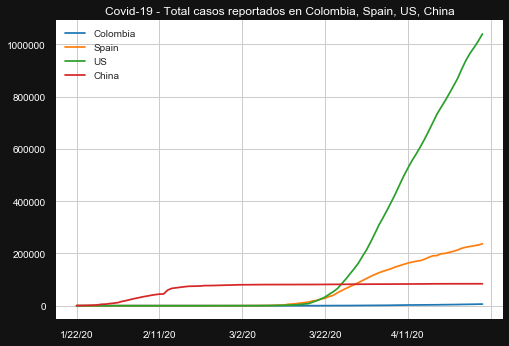

In [12]:
# Definimos una lista de las regiones que estamos usando para comparar
countries = ['Colombia','Spain','US','China']

#configure graphics
ax = plt.subplot()
#ax.set_facecolor('black')
ax.figure.set_facecolor('#121212')
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')
ax.set_title("Covid-19 - Total casos reportados en Colombia, Spain, US, China", color='white')


for country in countries:
    confirmed[country].plot(label=country)



plt.grid(True, which='both')
plt.legend(loc='upper left', shadow=True, facecolor='white', framealpha=1)
plt.show() 

Ahora la tendencia de los paises que seleccionamos en el un histograma

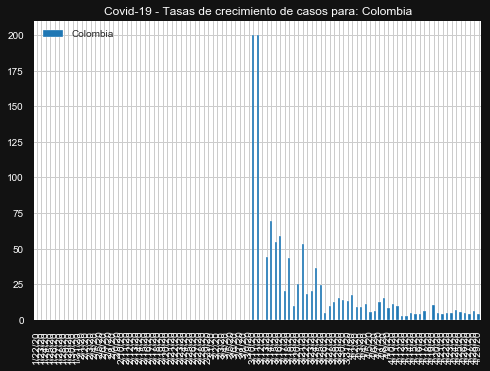

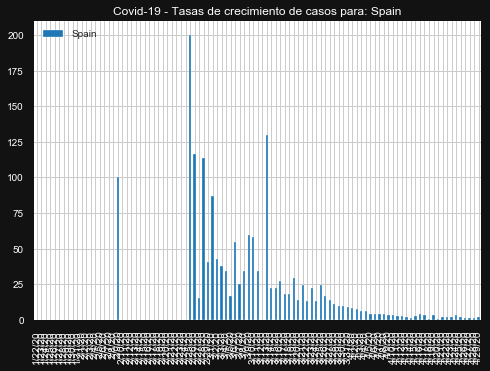

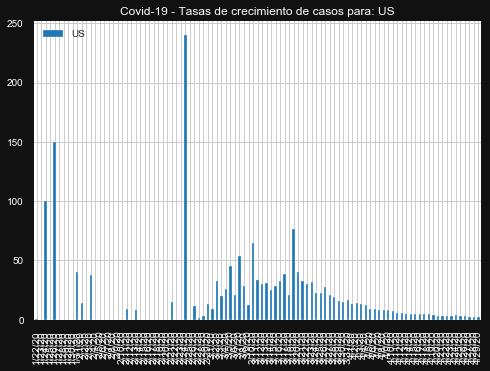

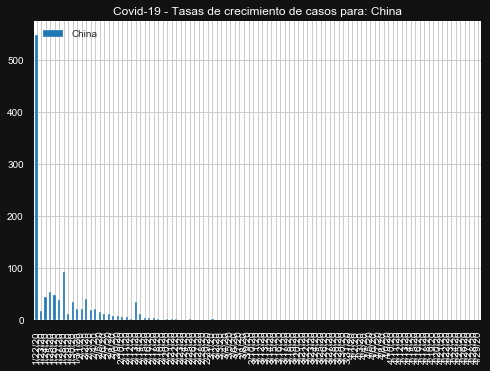

In [13]:
# Definimos una lista de las regiones que estamos usando para comparar
countries = ['Colombia','Spain','US','China']

#configure graphics


for country in countries:
    ax = plt.subplot()
    #ax.set_facecolor('black')
    ax.figure.set_facecolor('#121212')
    ax.tick_params(axis='x', colors='white')
    ax.tick_params(axis='y', colors='white')
    ax.set_title("Covid-19 - Tasas de crecimiento de casos para: {}".format(country), color='white')
    
    growth_rate[country].plot.bar()



    plt.grid(True, which='both')
    plt.legend(loc='upper left', shadow=True, facecolor='white', framealpha=1)
    plt.show() 

En los graficos anteriores es posible evidenciar cuando fueron las tasas de crecimiento mas elevadas para los diferentes paises que estamos comparando.

Ahora volvamos con una gráfica mas similar a la primera y veamos como se commportaron estos paises con respecto a las muertes.

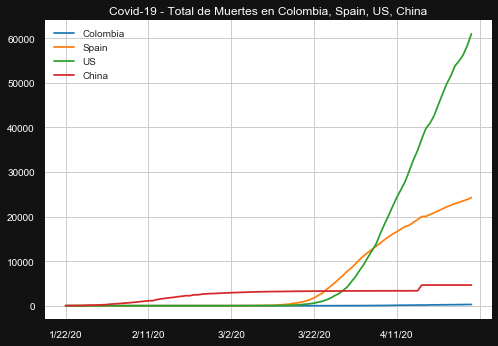

In [14]:
# Definimos una lista de las regiones que estamos usando para comparar
countries = ['Colombia','Spain','US','China']

#configure graphics
ax = plt.subplot()
#ax.set_facecolor('black')
ax.figure.set_facecolor('#121212')
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')
ax.set_title("Covid-19 - Total de Muertes en Colombia, Spain, US, China", color='white')


for country in countries:
    deaths[country].plot(label=country)



plt.grid(True, which='both')
plt.legend(loc='upper left', shadow=True, facecolor='white', framealpha=1)
plt.show() 

Ahora la tasa de muertes para cada uno de estos paises:

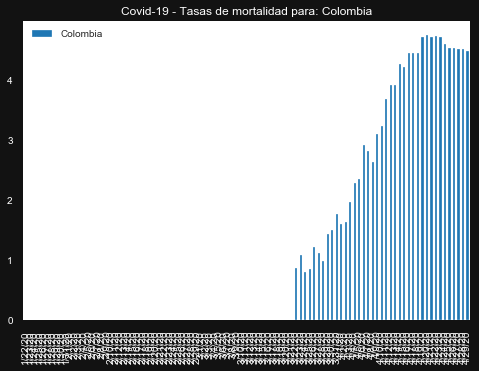

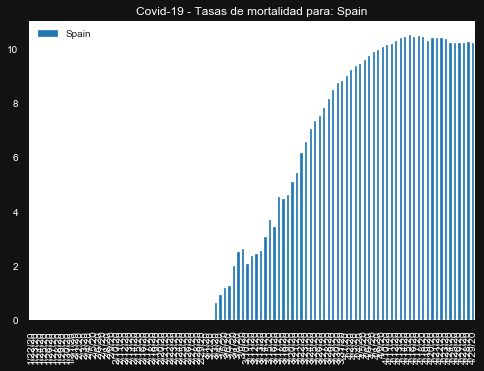

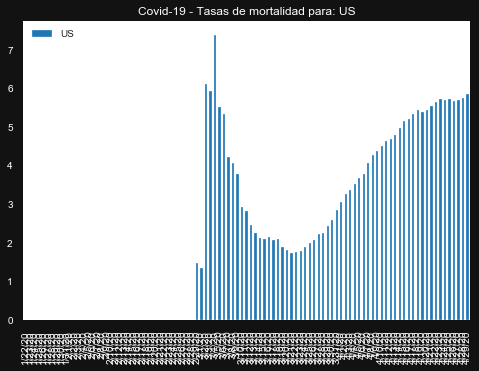

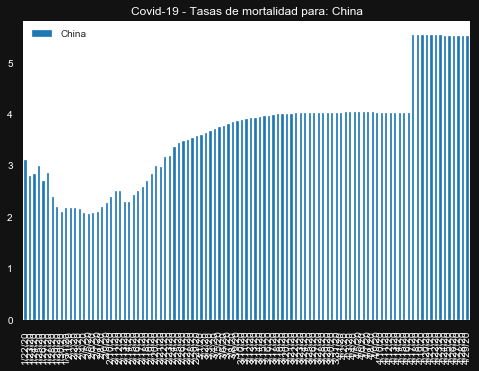

In [15]:
# Definimos una lista de las regiones que estamos usando para comparar
countries = ['Colombia','Spain','US','China']

#configure graphics


for country in countries:
    ax = plt.subplot()
    #ax.set_facecolor('black')
    ax.figure.set_facecolor('#121212')
    ax.tick_params(axis='x', colors='white')
    ax.tick_params(axis='y', colors='white')
    ax.set_title("Covid-19 - Tasas de mortalidad para: {}".format(country), color='white')
    
    death_rate[country].plot.bar()



    #plt.grid(True, which='both')
    plt.legend(loc='upper left', shadow=True, facecolor='white', framealpha=1)
    plt.show() 

Ahora Hagamos un ejercicio de predicción, suponiendo una tasa de crecimiendo de un **10%** vamos a predecir los valore para algunos dias adelante a partir de hoy y veamos como se comportan los resultados.

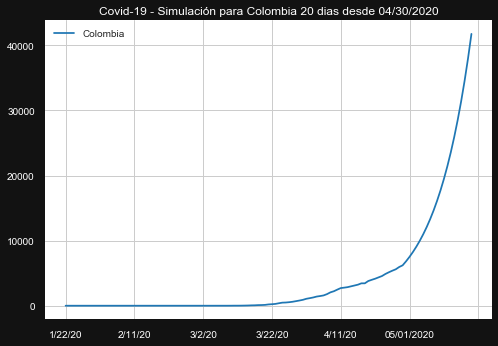

In [16]:
# Simulacion de casos a futuro
simulated_growth_rate = 0.10
days = 20 

today = pd.to_datetime('today').strftime('%m/%d/%Y')
dates = pd.date_range(start=today, periods=days, freq='D')
dates = pd.Series(dates)
dates = dates.dt.strftime('%m/%d/%Y')

simulated = confirmed.copy()
simulated = simulated.append(pd.DataFrame(index=dates))

for day in range(len(confirmed), len(simulated)):
    simulated.iloc[day] = simulated.iloc[day - 1] * (1 + simulated_growth_rate)

    
#configure graphics
ax = plt.subplot()
#ax.set_facecolor('black')
ax.figure.set_facecolor('#121212')
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')
ax.set_title(f'Covid-19 - Simulación para Colombia {days} dias desde {today}', color='white')
simulated['Colombia'].plot()
plt.grid(True, which='both')
plt.legend(loc='upper left', shadow=True, facecolor='white', framealpha=1)
plt.show()

Lo que obtenemos es que matematicamente hablando si colombia continuara con un crecimiento de **10%** de forma constante al primeto de mayo tendria una cifra de contagiados cercana a los **15000**.

La tasa de crecimiento estimada para el 15 de Abril es de **4.229607**, que pasaria si se continua con esta tasa de crecimiento:

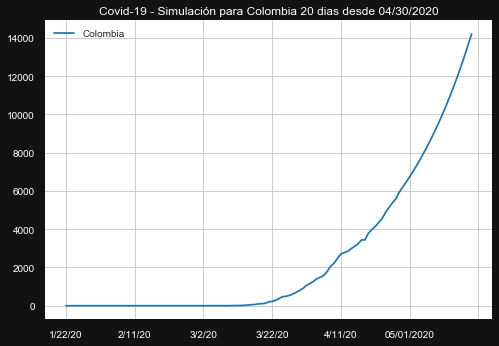

In [17]:
# Simulacion de casos a futuro
simulated_growth_rate = 4.229607 / 100 
days = 20 

today = pd.to_datetime('today').strftime('%m/%d/%Y')
dates = pd.date_range(start=today, periods=days, freq='D')
dates = pd.Series(dates)
dates = dates.dt.strftime('%m/%d/%Y')

simulated = confirmed.copy()
simulated = simulated.append(pd.DataFrame(index=dates))

for day in range(len(confirmed), len(simulated)):
    simulated.iloc[day] = simulated.iloc[day - 1] * (1 + simulated_growth_rate)

    
#configure graphics
ax = plt.subplot()
#ax.set_facecolor('black')
ax.figure.set_facecolor('#121212')
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')
ax.set_title(f'Covid-19 - Simulación para Colombia {days} dias desde {today}', color='white')
simulated['Colombia'].plot()
plt.grid(True, which='both')
plt.legend(loc='upper left', shadow=True, facecolor='white', framealpha=1)
plt.show()

Con la tasa de crecimiento actual al primero de mayo se tendria una cifra cercana a las **6000** personas.

# Predicción usando [Facebook Prophet]('https://facebook.github.io/prophet/docs/quick_start.html'). 

Esta libreria la pone a disposición facebook y permite a partir de ...(teoria de esta libreria AQUI)

In [18]:
days_to_predict=15
country='Colombia' # You can try others like: 'Spain','US', 'China'
m = Prophet()
ds= pd.DataFrame()
ds["ds"] = confirmed[country].index
ds["y"] = confirmed[country].values
ds
m.fit(ds)
future = m.make_future_dataframe(periods=days_to_predict)
future.tail()
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,yhat,yhat_lower,yhat_upper
109,2020-05-10,7879.183626,7716.553353,8047.584598
110,2020-05-11,8059.682467,7877.968586,8252.729741
111,2020-05-12,8261.910408,8078.952650,8462.979487
112,2020-05-13,8462.867772,8265.329286,8694.286516
113,2020-05-14,8613.153993,8390.106191,8868.234317


### Predicción de casos confirmados

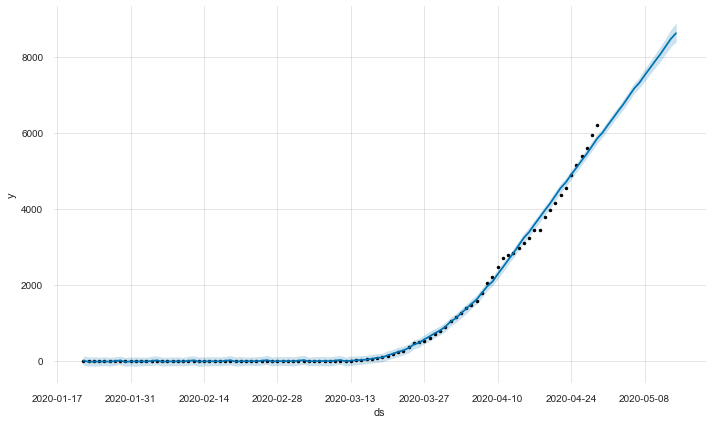

In [19]:
fig1 = m.plot(forecast)

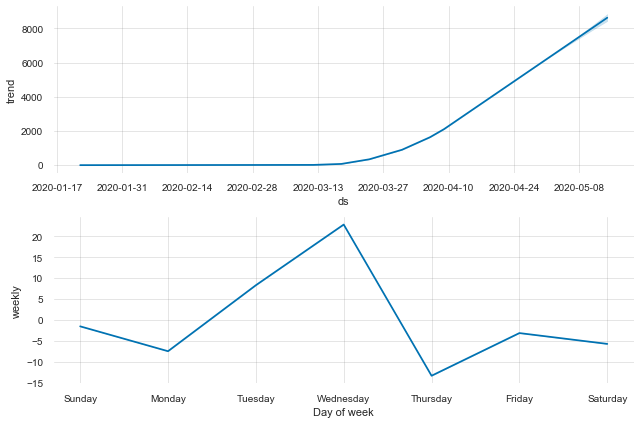

In [20]:
fig2 = m.plot_components(forecast)

__*Este es un ejercicio de análisis de dstos simple para explicar la situación actual de colombia frente a otros paises, los valores aqui mostrados se obtuvieron de fuentes externas a ESRI Colombia y que son los que en la actualidad se consideran los mas validos.*__